# Heart Disease Prediction

Every year, there are estimated 17.9 million deaths due to heart disease according to WHO.

In this project, we'll analyze patient data to identify key risk factors associated with heart disease and build a model to predict an individual’s likelihood of developing it in the future.

Heart Disease dataset: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

In [176]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [177]:
df = pd.read_csv("heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: resting blood pressure [mm Hg]
5. Cholesterol: serum cholesterol [mm/dl]
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10. Oldpeak: oldpeak = ST [Numeric value measured in depression]
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. HeartDisease: output class [1: heart disease, 0: Normal]

In [178]:
print(df.dtypes)

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


In [179]:
print(df.dtypes[df.dtypes == 'object'])
print(df.dtypes[df.dtypes == 'int64'])

Sex               object
ChestPainType     object
RestingECG        object
ExerciseAngina    object
ST_Slope          object
dtype: object
Age             int64
RestingBP       int64
Cholesterol     int64
FastingBS       int64
MaxHR           int64
HeartDisease    int64
dtype: object


According to the first 5 rows, FastingBS and HeartDisease seem to be categorical even though their data type is int64.

In [180]:
df["FastingBS"].unique(), df["HeartDisease"].unique()

(array([0, 1]), array([0, 1]))

# Data Cleaning

## Missing data handling

In [181]:
df.isna()
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

No missing data!

## Inappropriate 0 values handling
Now we will check if there's any illogical 0 values among numerical features.

In [182]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


RestingBP (Resting Blood Pressure) and Choresterol min values are 0, which is impossible. We will handle these accordingly to their number of 0 values presenting in the dataset.

In [183]:
df[df["RestingBP"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [184]:
df[df["Cholesterol"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


For RestingBP, since there's only one 0 value, we can remove this row and it will not affect our study. However, since there are a significant amount of 0 values as Cholesterol, we will replace those with median values based on whether they have a Heart Disease or not.  

In [185]:
#Remove row with 0 RestingBP from dataset
df = df[df["RestingBP"] != 0]

In [186]:
#Cholesterol column separated by Heart Disease 
C_no_disease = df.loc[df["HeartDisease"]==0, "Cholesterol"]
C_with_disease = df.loc[df["HeartDisease"]==1, "Cholesterol"]

#Replace each 0 value with its according median, store to new set
Cholesterol_no_heartdisease = C_no_disease.replace(to_replace = 0, value = C_no_disease.median())
Cholesterol_with_heartdisease = C_with_disease.replace(to_replace = 0, value = C_with_disease.median())

#Assign new Cholesterol set back to original data
df.loc[df["HeartDisease"]==0, "Cholesterol"] = Cholesterol_no_heartdisease
df.loc[df["HeartDisease"]==1, "Cholesterol"] = Cholesterol_with_heartdisease

In [187]:
df[["Cholesterol", "RestingBP"]].describe()

,Cholesterol,RestingBP
count,917.000000,917.000000
mean,239.700109,132.540894
std,54.352727,17.999749
min,85.000000,80.000000
25%,214.000000,120.000000
50%,225.000000,130.000000
75%,267.000000,140.000000
max,603.000000,200.000000


Min values of both columns have changed! Now we can move on to EDA.

# EDA (Exploratory Data Analysis)
EDA of the categorical data will help us identify if our dataset is imbalanced/skewed, prevents biasing and helps with Feature Selection later on.

First, we will analyze each categorical feature individually to understand our dataset, then their relations to HeartDisease to idenity useful features.

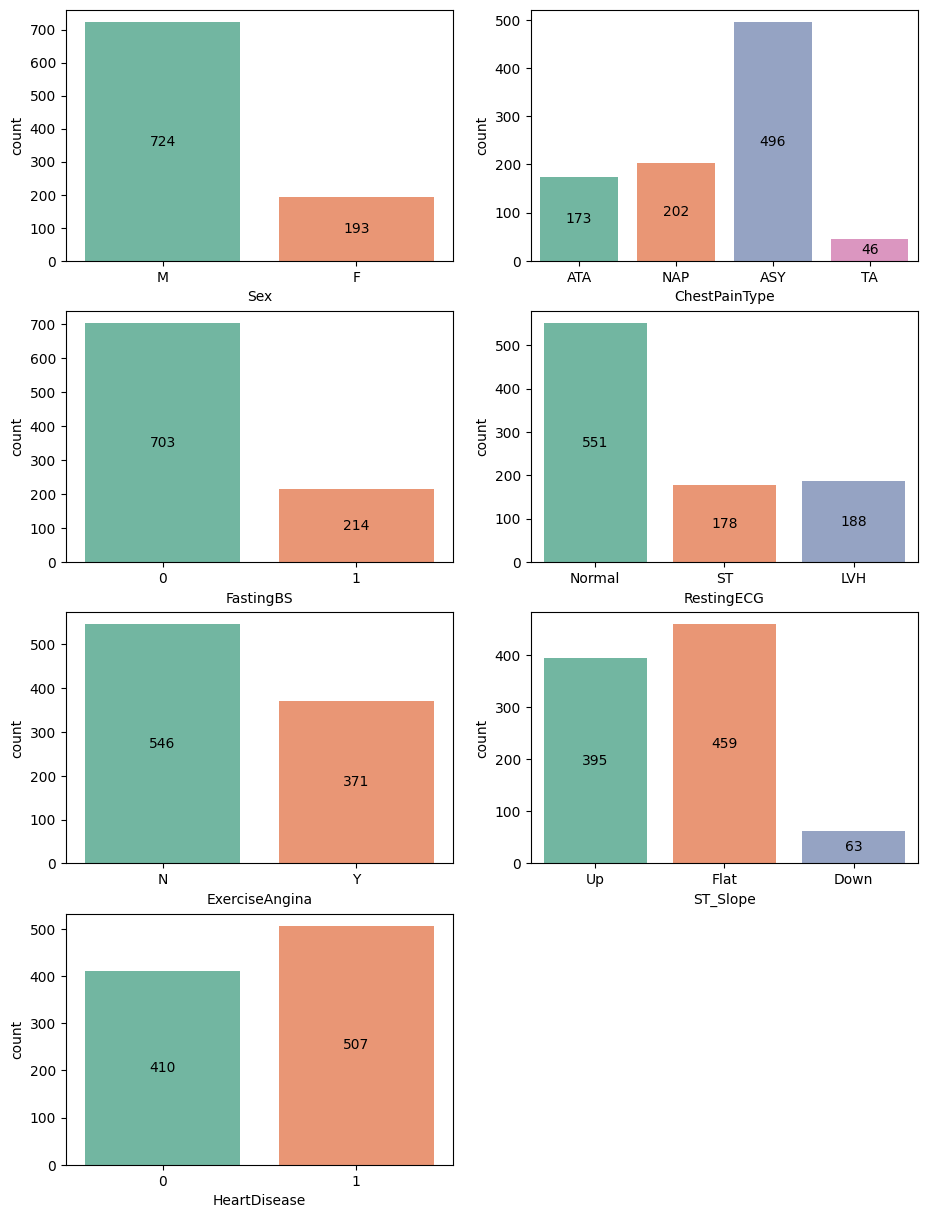

In [188]:
categorical = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope", "HeartDisease"]

fig = plt.figure(figsize=(11,15))

for idx, col in enumerate(categorical): #enumerate assigns index to each column name in categorical
    ax = plt.subplot(4, 2, idx+1)
    sns.countplot(x=df[col], hue = df[col], legend = False, palette="Set2") #hue + legend parameters help enable pallete, else all columns are blue
    for container in ax.containers:
        ax.bar_label(container, label_type = "center") #show counts

From these graphs, we can see that:
- The dataset is highly skewed towards male patients - 725 male patients vs 193 female. This could introduce bias into the model, potentially reducing its accuracy when predicting outcomes for female patients.
- Significant amount of patients had ASY (asymptomatic) chest pain type.
- Most patients had blood sugar lower than 120 mg/dL.
- The dataset shows a roughly even split between patients with and without heart disease.

Now we will analyze how each feature correlates to heart disease diagnosis.

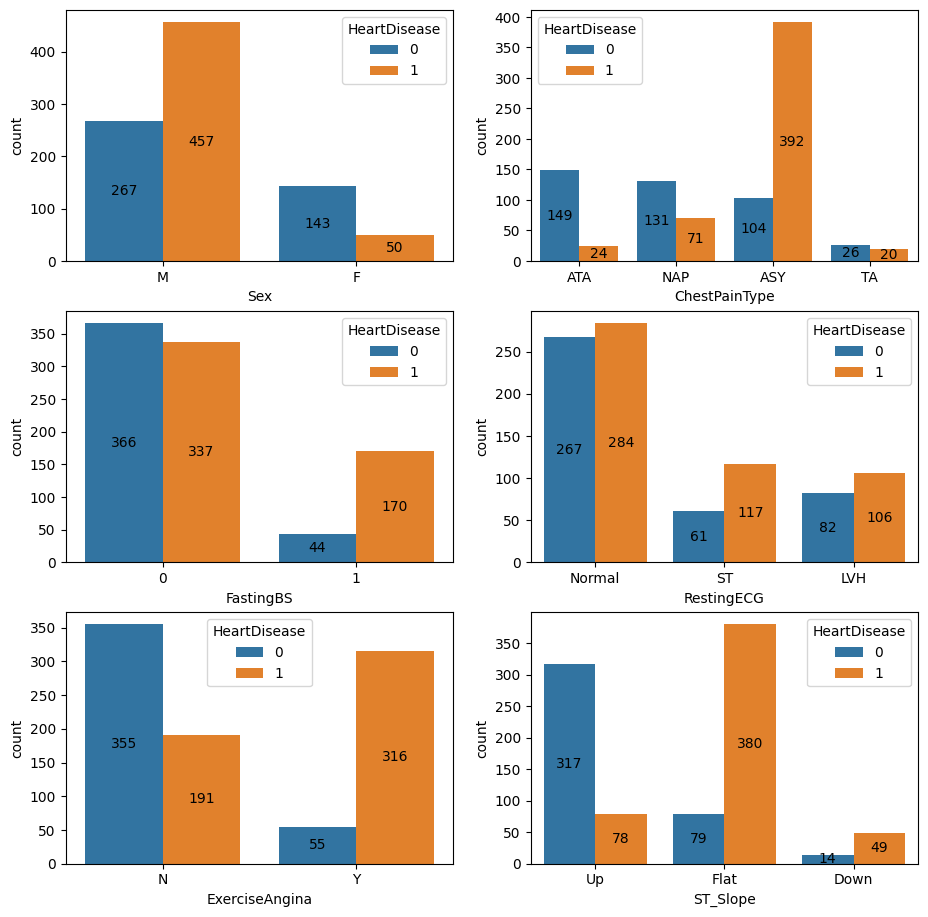

In [189]:
fig = plt.figure(figsize=(11,15))

for idx, col in enumerate(categorical[:-1]): #drop Heart Disease column
    ax = plt.subplot(4, 2, idx+1)
    sns.countplot(x=df[col], hue=df["HeartDisease"]) #separate each value options by HeartDisease
    for container in ax.containers:
        ax.bar_label(container, label_type="center") #show counts

- We can further notice how skewed the dataset is towards male patients. Only 50 female patients in the dataset have been diagnosed with heart disease.
- Significant amount of patients had ASY (asymptomatic) chest pain type. This means that most of the time, heart disease was diagnosed without any symptom.
- We can see that blood sugar greater than 120 mg/dl, exercise-induced angina and flat ST slope all show strong associations with a higher likelihood of heart disease.

# Feature Selection

In addition to EDA conducted above, which shows strong correlations between FastingBS, ExerciseAngina, ST_Slope and Heart Disease, we can create a correlation heatmap to explore how all numerical and categorical features correlate with each other and with the Heart Disease column.

To do so, first we need to convert all our categorical values into dummies so we can plot them.

In [190]:
df_new = pd.get_dummies(df, drop_first = True).astype(int) #int converts True False to 1 0 
df_new.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0,0,1,0,1,0,1,0,0,0,1


<Axes: >

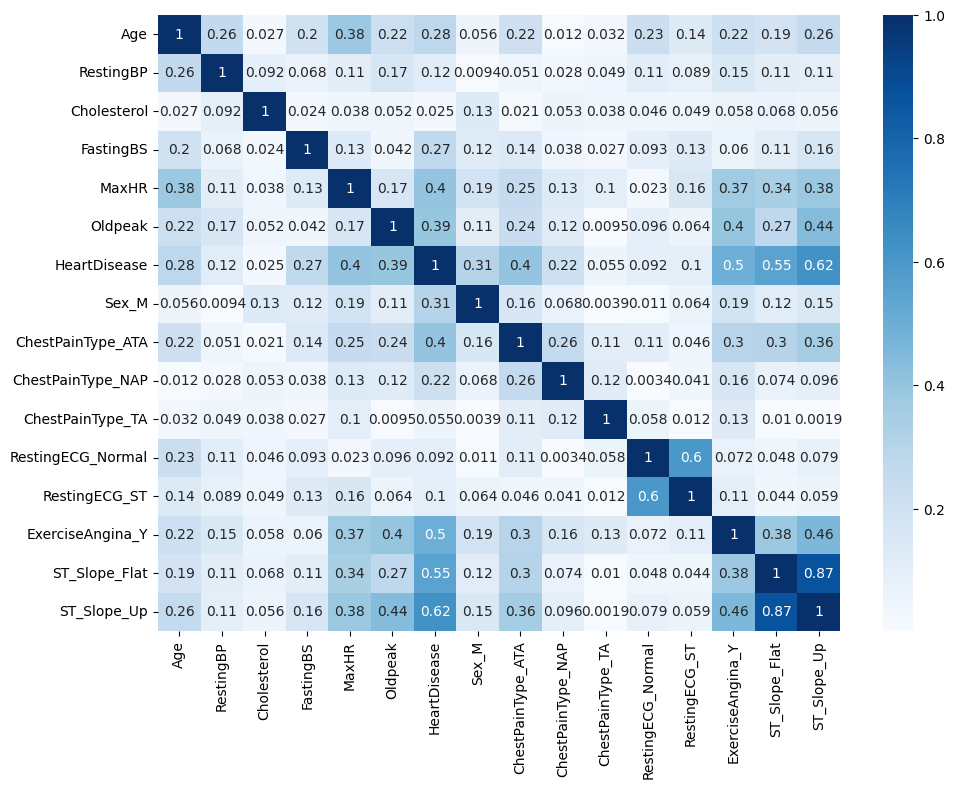

In [191]:
correlations_table = abs(df_new.corr())
plt.figure(figsize=(11,8))
sns.heatmap(correlations_table, annot=True, cmap="Blues")

Let's remove weak correlations (less than 0.3) so we get a clearer picture.

<Axes: >

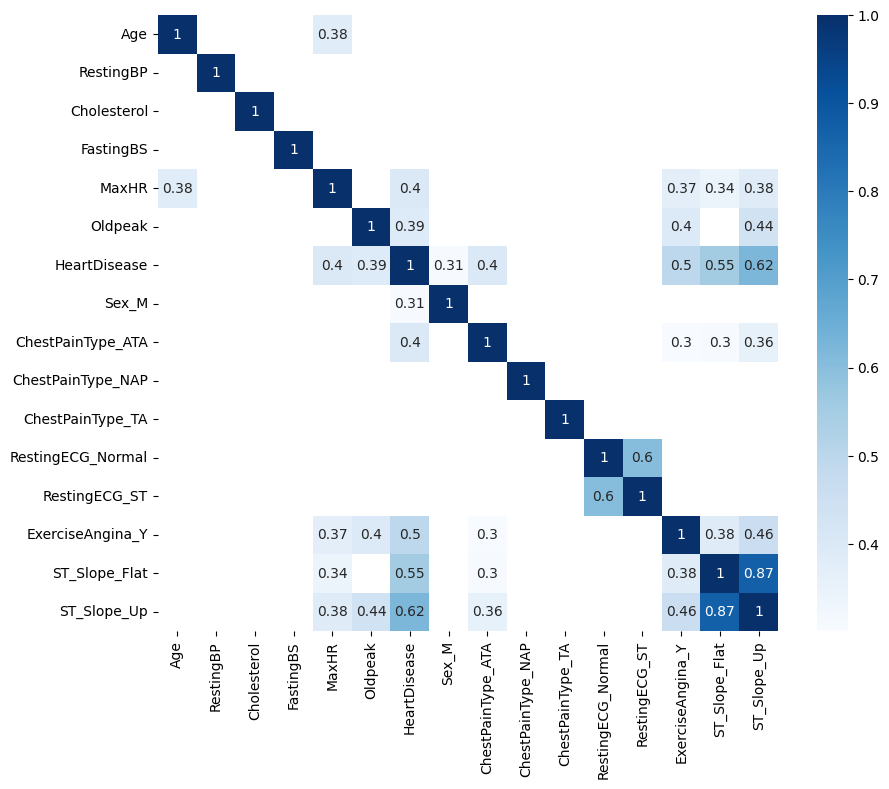

In [192]:
plt.figure(figsize=(10,8))
sns.heatmap(correlations_table[correlations_table >= 0.3], annot=True, cmap="Blues")

From the correlation heatmap, we can narrow down the features to those below to train our model with:
- MaxHR
- Oldpeak
- Sex
- ChestPainType_ATA
- ExerciseAngina_Y
- ST_Slope_Flat
- ST_Slope_Up

Time to create our model using these features!

# Classifier Building

Let's split our dataset into training and test sets. We'll choose KNN model for this project. 

In [193]:
X = df_new.drop(["HeartDisease"], axis=1)
y = df_new["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 417)

features = [
    "MaxHR",
    "Oldpeak",
    "Sex_M",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_test_scaled = scaler.transform(X_test[features])

## Hyperparameter Optimization

To achieve the best performance, we'll optimize the model’s hyperparameters to identify the configuration that yields the highest accuracy. We'll use grid search to explore the following range of values for a couple of hyperparameters:

- For k (n_neighbors in scikit-learn) we will use values in the range of 1 to 20.

- For distance metrics - minkwoski and manhattan.

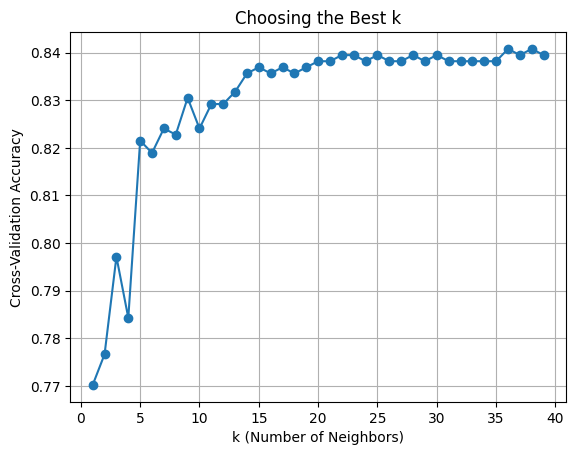

In [204]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

k_values = range(1, 40)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Choosing the Best k')
plt.grid(True)
plt.show()

We can see that the accuracy of the model does not increase much when n is over 23. Therefore, to avoid overfitting, let's keep the range from 1 to 24.

In [205]:
grid_params = {"n_neighbors": range(1, 24),
                "metric": ["minkowski", "manhattan"]
              }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)
knn_grid.best_score_*100, knn_grid.best_params_

(np.float64(83.94954507857733), {'metric': 'manhattan', 'n_neighbors': 20})

We got a 83.94% accuracy with n=20 and mahattan distance metrics! We will try to predict couple samples using these parameters.

In [206]:
sample1 = pd.DataFrame([{
    "MaxHR": 150,
    "Oldpeak": 0.8,
    "Sex_M": 1,
    "ExerciseAngina_Y": 0,
    "ST_Slope_Flat": 1,
    "ST_Slope_Up": 0
}])

sample2 = pd.DataFrame([{
    "MaxHR": 130,
    "Oldpeak": 1.3,
    "Sex_M": 0,
    "ExerciseAngina_Y": 1,
    "ST_Slope_Flat": 0,
    "ST_Slope_Up": 1
}])

prediction1 = knn_grid.best_estimator_.predict(sample1[features].values)
prediction2 = knn_grid.best_estimator_.predict(sample2[features].values)

print("Predicted Heart Disease (1 = Yes, 0 = No):", prediction1[0])
print("Predicted Heart Disease (1 = Yes, 0 = No):", prediction2[0])

Predicted Heart Disease (1 = Yes, 0 = No): 0
Predicted Heart Disease (1 = Yes, 0 = No): 0


# Model Evaluation
To measure how good our model actually performs, we need to test it with data it's never been exposed to before which is the test set.

In [207]:
predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f" Model Accuracy on test set: {accuracy*100:.2f}")

 Model Accuracy on test set: 84.78


We achieved pretty high accuracy on both the training and the test sets. It's not common that the test set has higher accuracy than the training set, but since the difference is only 0.83%, it should not be a concern here. 

# Summary and Next Steps
Our final model was trained using the following features:

- MaxHR
- Oldpeak
- Sex_M
- ExerciseAngina_Y
- ST_Slope_Flat
- ST_Slope_Up

and had a test set accuracy of 84.78%.

However, given the limitations of our data this accuracy might not be indicative of a well performing model.
A few things we could try next to get better results:
- Try out different features.
- Explore other algorithms that might perform better than k-NN.